# Cubed-sphere grid explanation with model electric potential

Cubed-sphere grids are the basis of the numerical implementation of the Lompe technique ([Laundal et al., 2022](https://doi.org/10.1029/2022JA030356)). This notebook is an example of how to use `cubedsphere` from the `secsy` submodule for simple modeling. We will use an electric potential, $\Phi$, from the empirical [Weimer (2005a](https://doi.org/10.1029/2004JA010884)[,b)](https://doi.org/10.1029/2005JA011270) model for the northern hemisphere, with solar wind velocity 350 km/s, IMF $B_y$ = 0 nT, $B_z=-4$ nT, solar wind density 2 particles per cm$^3$, and dipole tilt angle $25^\circ$. This refered to as the "Weimer potential" in this notebook. 

When ignoring inductive effects, this (scalar) potenital field describes the ionospheric electric field, $\mathbf{E} = -\nabla\Phi$. The divergence of a scala field can be found using the differentiation matrices $\mathbb D_{\mathbf{e}\cdot\nabla}$, $\mathbb D_{\mathbf{n}\cdot\nabla}$ obtained from a cubed-sphere grid object, `CSgrid.get_Le_Ln()`. We can also get the divergence of the electric field by using the $\mathbb D_{\nabla\cdot}$ matrix from `CSgrid.divergence()`.

Below we:
 1. Set up the cubed-sphere projection and grid
 2. Read a Weimer model output file and interpolate the electric potential to the grid
 3. Find gradients of the electric potential - the eastward and northward electric field
 4. Get the divergence of the electric field and multiply by $\epsilon_0$ to get charge density
 5. Plot
 
Import relevant modules:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lompe
from lompe.dipole import Dipole
from scipy.interpolate import griddata
from matplotlib.colors import LinearSegmentedColormap


RE = 6371.2e3    # Earth's radius [m]
HI = 110e3       # ionospheric altitude [m]
eps0 = 8.854e-12 # electric permittivity of free space 
stencil_size = 1 # size of the stencil used for numerical differentiation

#### Set up cubed-sphere grid

Before setting up a cubed-sphere grid, a cubed-sphere projection must be defined. We initialize a `CSprojection` that sets up a cube face centered at the north magnetic pole - `position` - and oriented along the meridian (`orientation` set to zero implies primary axis of the grid ($\xi$-axis) is oriented in the east-west direction, positive towards the east). The way we initialize the projection here, makes the global system *centered dipole*. If `position` is offset from the global pole and/or `orientation` is not zero, the `CSprojection` will first rotate the coordinates into a local system where the center coordinates from `position` define the north pole and the `orientation` specifies the primary axis. Then the spherical coordinates of the local system is projected to the cube face. The cubed-sphere projection uses $\xi$, $\eta$ coordinates. In this example, the local and global spherical systems are the same. 

A `CSgrid` object is initialized using the projection, as well as parameters for size, resolution and altitude of the grid. `CSgrid` sets up an almost equal area grid in the cubed-sphere coordinates. Here, the `CSgrid` has dimensions 18 000$\times$ 18 000 km, a resolution of 80$\times$80 km, and is set to the ionospheric altitude of 110 km.

In [2]:
L, W, Lres, Wres = 18000e3, 18000e3, 80e3, 80e3                     # [m]
projection = lompe.cs.CSprojection(position=(0, 90), orientation=0) # east, west oriented xi-axis
grid = lompe.cs.CSgrid(projection, L, W, Lres, Wres, R=RE+HI)       # set to ionospheric altitude

Usually, a more local grid is preferred, and the size/resolution of the grid adjusted to fit the data.

For this example, we assume that the grid is defined by *magnetic* coordinates, which means we assume the grid is centered at the centered dipole magnetic north pole. This makes interpolation of the Weimer potenital onto the `CSgrid` easier, and data defined on the grid must also be given in centered dipole coordinates.

(NOTE: For the implemented Lompe technique (see Notebooks 07 and 08) the grid is by default interpreted as of it is defined with a global system in *geographic*. The `dipole` keyword can be set to `True` to work in the centered dipole system.) 

#### Electric potential

Next, we read the file containing the Weimer potential and interpolate it to our grid:

In [3]:
# read potential file:
weimer = np.load('./datasets/interpolated_weimer.npz')
Phi = weimer['Phi']
latxx = weimer['lat'] # magnetic lat
lonxx = weimer['lon'] # magnetic lon

# interpolate potential to grid coordinates
xi, eta = grid.projection.geo2cube(lonxx, latxx)
Phi     = griddata((xi.flatten(), eta.flatten()), Phi.flatten(), (grid.xi.flatten(), grid.eta.flatten()), 
                   fill_value = 0, method = 'cubic').reshape(grid.shape)

#### Horizontal electric field

Matrices $\mathbb D_{\mathbf{e}\cdot\nabla}$, $\mathbb D_{\mathbf{n}\cdot\nabla}$ that can be obtained from `CSgrid.get_Le_Ln()` produce gradients (derivatives) in eastward and northward direction of a scalar field defined on the grid, respectively. If $\mathrm{\underline{\Phi}}$ is the $N$ element column vector containing the electric potential defined in the center of each of the $N$ cells in `CSgrid`, the $N$ element column vectors containing the eastward $E_e$ and northward $E_n$ electric field components for each of the grid cells can be found through matrix multiplication:
\begin{equation*}
    \mathrm{\underline{E}}_e = -\mathbb D_{\mathbf{e}\cdot\nabla}\mathrm{\underline{\Phi}},
\end{equation*}
\begin{equation*}
    \mathrm{\underline{E}}_n = -\mathbb D_{\mathbf{n}\cdot\nabla}\mathrm{\underline{\Phi}}.
\end{equation*}
$\mathrm{\underline{E}}_e$ and $\mathrm{\underline{E}}_n$ are column vectors with elements of the eastward components of the electric field and the northward components of the electic field on the $N$ cells of `CSgrid`, respectively.

The elements of the differentiation matrices are calculated using a central difference scheme for the inner grid cells, and forward and backward difference schemes near the edges. The ``stencil_size`` scales the interval for the finite difference calculation of the derivatives. A larger stencil size will usually yield more accurate derivatives, but is more sensitive to noise. We use ``stencil_size = 1``, which means that the derivatives are calculated with a 3-point stencil.

We choose to return the differation matrices as sparse (this reduces the size of the matrix making computations more effective).

In [4]:
# use cubedsphere differentiation matrices to get electric field
De, Dn = grid.get_Le_Ln(S=stencil_size, return_sparse=True)
E_e = -De.dot(Phi.flatten()).reshape(grid.shape)
E_n = -Dn.dot(Phi.flatten()).reshape(grid.shape)

#### Divergence of electric field

We can also calculate the divergence of a vector field defined on the `CSgrid` using the matrix $\mathbb D_{\nabla\cdot}$ from `CSgrid.divergence()`. $\mathbb D_{\nabla\cdot}$ produces the divergence of a vector field evaluated at the center of the grid cells. $\mathbb D_{\nabla\cdot}$ is a $N\times 2N$ matrix that operates on the electric field defined on the `CSgrid` that is a $2N$ column vector containing $\mathrm{\underline{E}}_e$ and $\mathrm{\underline{E}}_n$.

The divergence of the electric field is then:
\begin{equation*}
    \mathrm{\underline{E}}_{\nabla\cdot} = \mathbb D_{\nabla\cdot}\begin{pmatrix}\mathrm{\underline{E}}_e\\\mathrm{\underline{E}}_n\end{pmatrix},
\end{equation*}
where $\mathrm{\underline{E}}_{\nabla\cdot}$ is an $N$ element column vectors that contains the divergence of the electric field defined on the cells in `CSgrid`. 

The divergence of the electric field is proportional to the charge density, $\rho_c$, through Gauss' law, $\rho_c = \epsilon_0\nabla\cdot\mathbf{E}$. 

$\epsilon_0=8.854\cdot 10^{-12}\ \frac{A^{2}s^4}{m^3kg}$ is the permittivity of free space (constant).

In [5]:
E_tot = np.hstack((E_e.flatten(), E_n.flatten()))

# use cubedsphere divergence matrix to get div(E)
Ddiv = grid.divergence(S=stencil_size, return_sparse=True)
divE = Ddiv.dot(E_tot).reshape(grid.shape)

# get charge density - Gauss' law
rho = divE * eps0

#### Plotting

We now make a figure illustrating the `CSgrid` as well as the parameters derived from the Weimer potential.

To avoid plotting results of edge effects, we remove the lower magnetic latitudes before plotting:

In [6]:
E_e[grid.lat < 61] = np.nan
E_n[grid.lat < 61] = np.nan
rho[grid.lat < 61] = np.nan

_*Upper row of panels*_

The grid cells are almost equal area in the cube coordinate system, but the projected area on the sphere changes with distance from the center of the cube face. To illustrate how the area of the grid cells decrease with distance from the center of the cube face, we include a colormap under the `CSgrid` showing the relative grid cell area (to a grid cell at the center of the cube face/grid). For illustration purposes, not all grid cells are plotted. We also make a simple illustration showing a cross-section of a cube face intersecting a sphere.

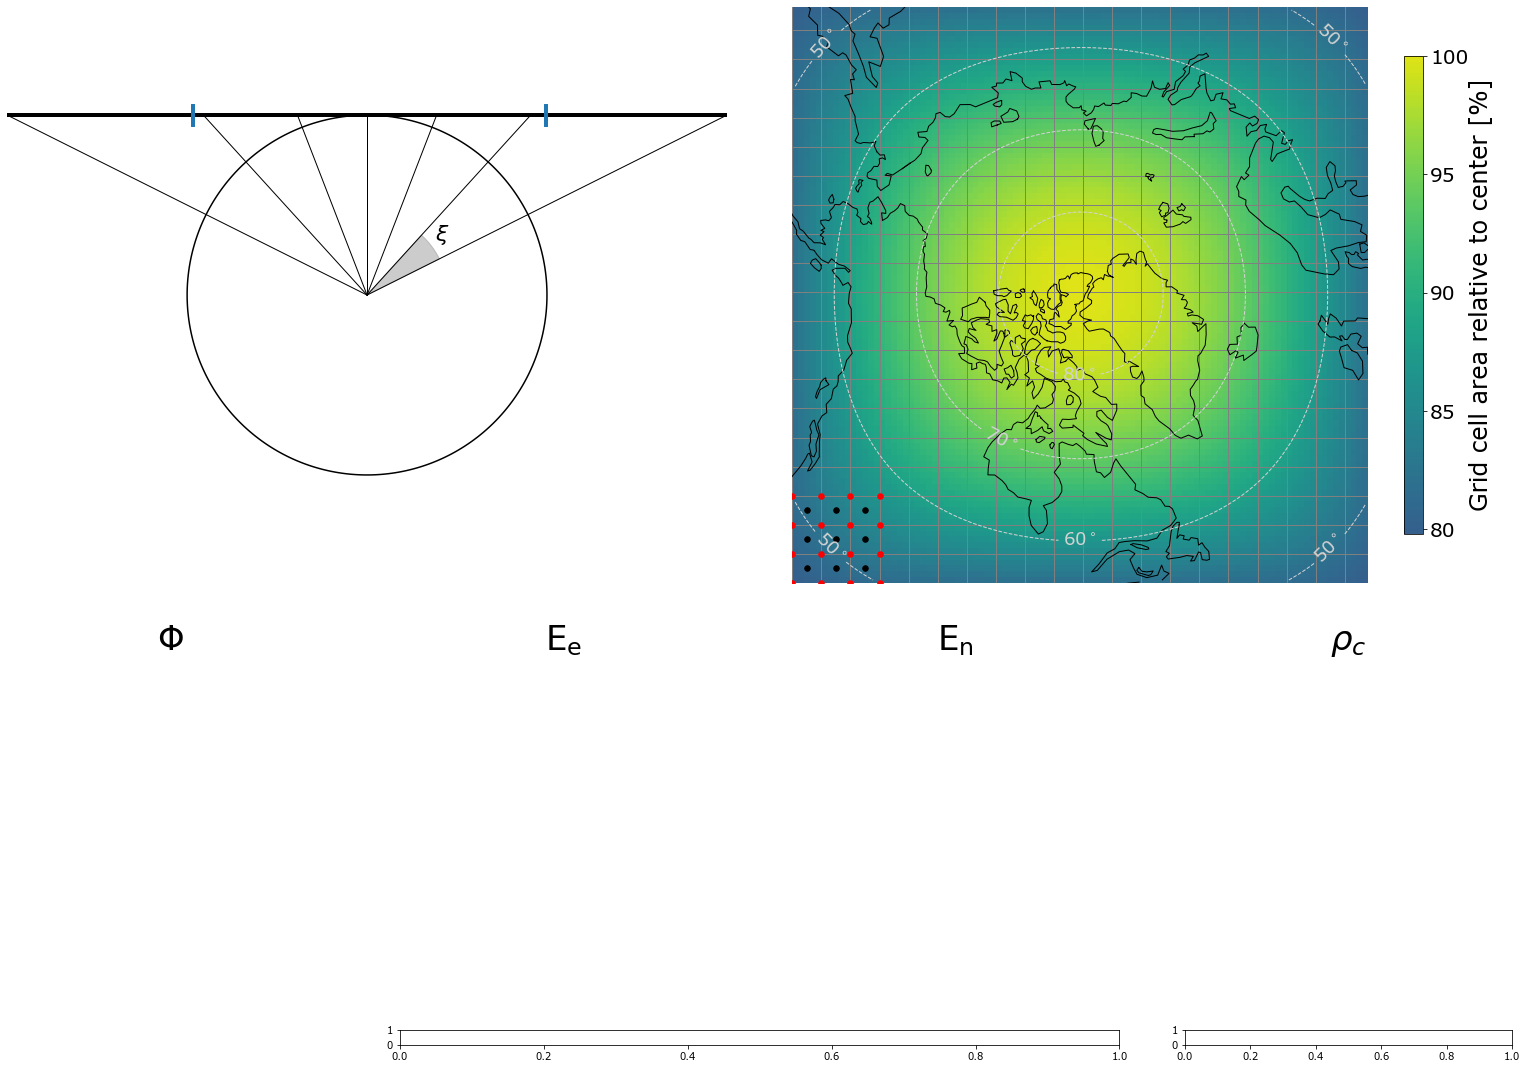

In [7]:
# Start by setting up figure and subplots:
fig = plt.figure(figsize = (22,16))
spec = fig.add_gridspec(4, 4, height_ratios=[6,.01,3,.15])
axs = {}

# upper row
axs['onsphere' ] = fig.add_subplot(spec[0, 0:2])
axs['grid'     ] = fig.add_subplot(spec[0, 2:4])

# lower row
axs['potential'] = fig.add_subplot(spec[2, 0  ])
axs['E_e'      ] = fig.add_subplot(spec[2, 1  ])
axs['E_n'      ] = fig.add_subplot(spec[2, 2  ])
axs['Ediv'     ] = fig.add_subplot(spec[2, -1 ])
axs['cbar1'    ] = fig.add_subplot(spec[3, 1:3])
axs['cbar2'    ] = fig.add_subplot(spec[3, -1 ])

# title axes
titleargs = {'fontsize':34, 'y':1.1}
axs['potential'].set_title(r'$\Phi$',                    **titleargs)
axs['E_e'      ].set_title(r'$\mathrm{E}_{\mathrm{e}}$', **titleargs)
axs['E_n'      ].set_title(r'$\mathrm{E}_{\mathrm{n}}$', **titleargs)
axs['Ediv'     ].set_title(r'$\rho_c$',                  **titleargs)

# adjust
fig.subplots_adjust(left=.03, right=.98, bottom=.08, top=.99)

for key in axs.keys():
    if key in ['cbar1', 'cbar2']:
        continue
    axs[key].set_axis_off()
    axs[key].set_aspect('equal')

    
#### A) example of cube face intersecting sphere 

# cross section of cube face that is intersecting a sphere
xs = np.linspace(-4,4,1000)
ys = np.linspace(-4,4,1000)
a, b = np.meshgrid(xs, ys)
C = a ** 2 + b ** 2 - 16         # function of a circle with radius 4
axs['onsphere'].contour(a, b, C, levels=[0], colors='black')
axs['onsphere'].plot([-8,8],[4,4], color='black', lw=4)

# lines from center of sphere to grid 
totang = np.arctan(8/4)
for i in np.arange(-totang,totang+.1,totang/3):
    xdist = np.tan(i)*4 # tan(colat)*radius
    axs['onsphere'].plot([0,xdist],[0,4], color='black', lw=1)

# indicate xi on one of the angles
xs = [0]
ys = [0]
for theta in np.linspace(np.pi/2-(totang/3)*2,np.pi/2-totang,9):
    xs.append(1.8*np.cos(theta))
    ys.append(1.8*np.sin(theta))
axs['onsphere'].fill(xs, ys, color='grey', alpha=.4)
axs['onsphere'].text(1.5, 1.2, r'$\xi$', size=22)

# indicate extent of example grid region with blue lines
yedge = np.tan((90-grid.lat.min())*np.pi/180.)*4 # tan(colat)*radius
axs['onsphere'].scatter([-yedge, yedge], [4, 4], c='C0', marker='$\mathrm{l}$', s=500, zorder=4)

# adjust
axs['onsphere'].set_xlim(-8,8)
axs['onsphere'].set_ylim(-6,6)
    
    
##### B) cubed sphere grid with coastlines

# add coastlines
for cl in grid.projection.get_projected_coastlines(resolution='110m'):
    lon, lat = grid.projection.cube2geo(cl[0], cl[1])
    cd = Dipole()                     # geo to CD
    mlat, mlon = cd.geo2mag(lat, lon) 
    xis, etas = grid.projection.geo2cube(mlon, mlat) 
    axs['grid'].plot(xis, etas, color='black', linewidth=1)

# plot some of the grid cells
STEP = 5 # plot every STEP grid boundary. Set this to an odd number
axs['grid'].plot(grid.xi_mesh[:, ::STEP], grid.eta_mesh[:, ::STEP], color = 'grey', lw = 1, zorder = 1)
axs['grid'].plot(grid.xi_mesh.T[:, ::STEP], grid.eta_mesh.T[:, ::STEP], color = 'grey', lw = 1, zorder = 1)

# adjust
xlim, ylim = (grid.xi_mesh[0, 0], grid.xi_mesh[-1, -1]), (grid.eta_mesh[0, 0], grid.eta_mesh[-1, -1])
axs['grid'].set_ylim(ylim)
axs['grid'].set_xlim(xlim)

# relative area - shade under grid region 
cmapIn = plt.get_cmap('viridis')
new_cmap = LinearSegmentedColormap.from_list('trunc({n},{a:.2f},{b:.2f})'.format(n=cmapIn.name, a=.3, b=.95),
                                             cmapIn(np.linspace(.3, .95, 100)))
ticks = np.linspace(.8, 1, 5)*100
areas = axs['grid'].pcolormesh(grid.xi, grid.eta, grid.A/grid.A.max()*100, cmap=new_cmap, zorder=0)

# color bar
cbar1 = fig.colorbar(areas, ax=axs['grid'], location='right', ticks=ticks, orientation='vertical', shrink=.8, 
                     aspect=25, pad=.05)
cbar1.ax.tick_params(labelsize=20)
cbar1.ax.set_ylabel('Grid cell area relative to center [%]', fontsize=24, labelpad=.2)

# add indication of grid cell center (red) and grid cell corner (black)
axs['grid'].scatter(grid.xi_mesh[:STEP*4:STEP, :STEP*4:STEP], grid.eta_mesh[:STEP*4:STEP,:STEP*4:STEP], c='red', s=30)
axs['grid'].scatter(grid.xi[STEP//2:STEP*3:STEP, STEP//2:STEP*3:STEP], grid.eta[STEP//2:STEP*3:STEP,STEP//2:STEP*3:STEP], c='black', s=30)

# add latitude contours
latargs = {'linestyles':'--', 'linewidths':1, 'levels':np.r_[-80:81:10], 'zorder':2}
co = axs['grid'].contour(grid.xi, grid.eta, grid.lat, colors='lightgrey', **latargs)
axs['grid'].clabel(co, co.levels, inline=True, fontsize=18, fmt='%1.0f$^\circ$');

_*Lower row of panels*_

The Weimer model potential, the eastward elecric field, the northward electric field, and the charge density are plotted in the lower row of panels:

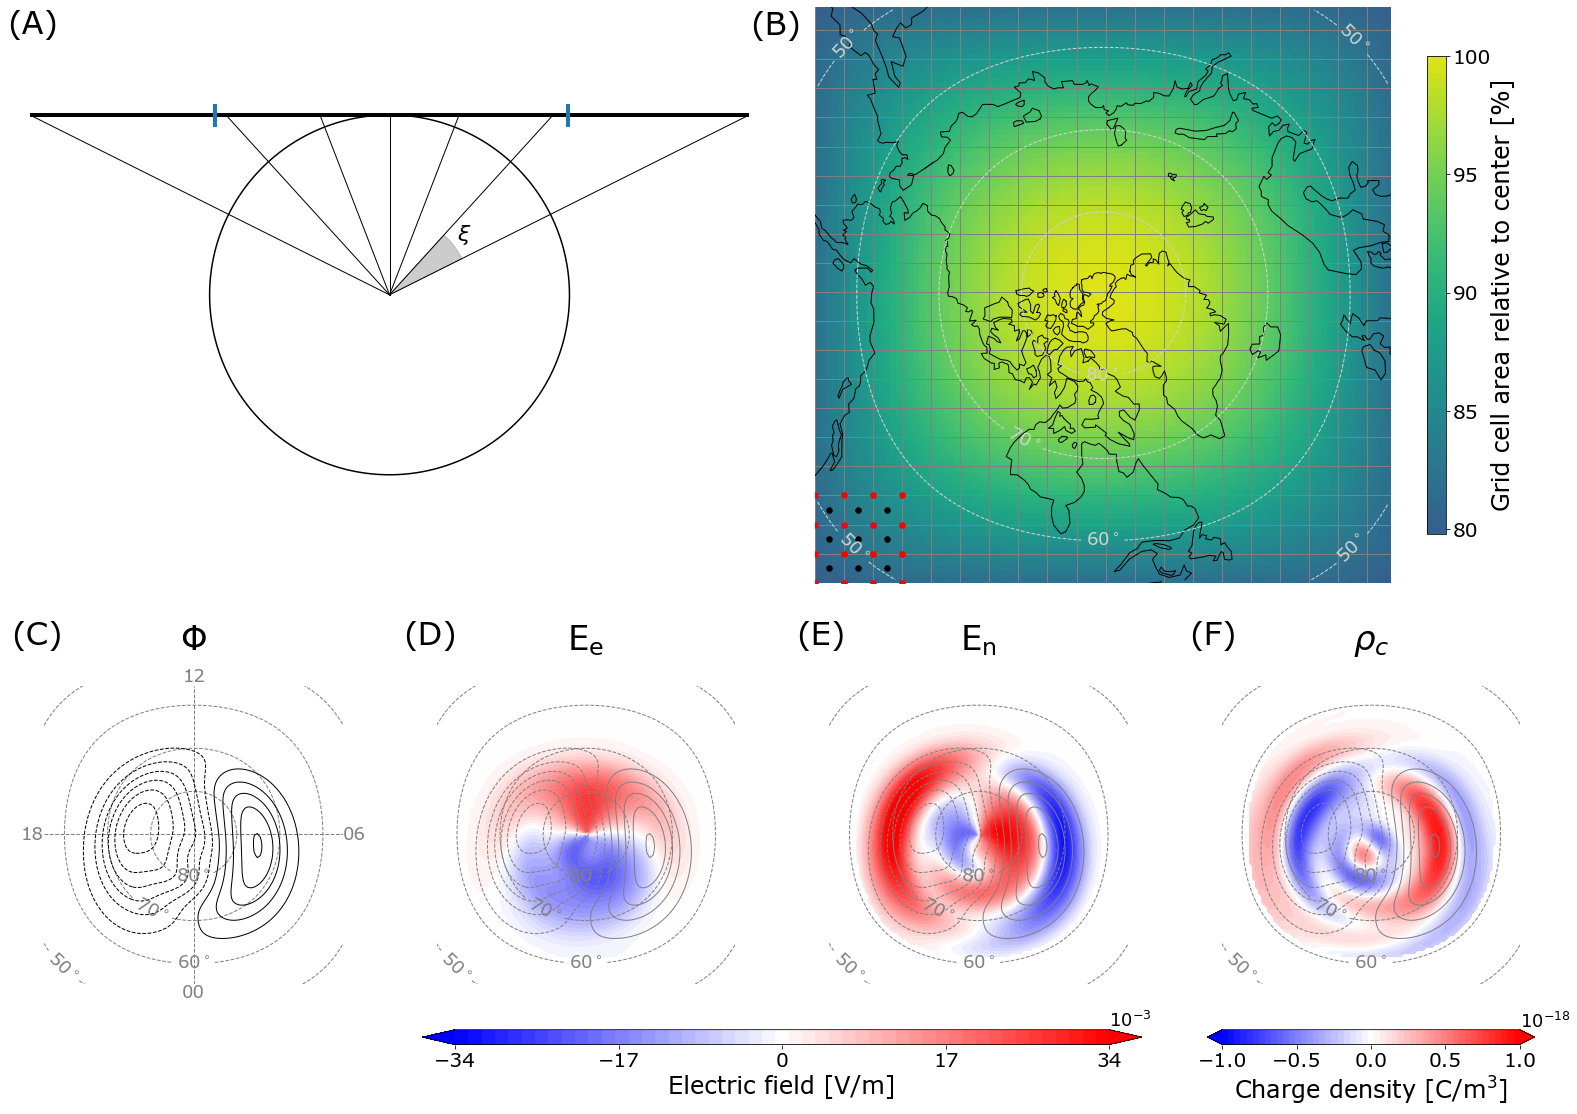

In [8]:
# set up axes
for key in axs.keys():
    if key in ['grid','onsphere', 'cbar1', 'cbar2']: 
        continue
    # latitude contours
    c = axs[key].contour(grid.xi, grid.eta, grid.lat, colors='grey', **latargs)
    axs[key].clabel(c, c.levels, inline=True, fontsize=18, fmt='%1.0f$^\circ$')
# add MLT labels
axs['potential'].plot([0, 0], [grid.eta.min(), grid.eta.max()], color='grey', linestyle='--', linewidth=1, zorder=2)
axs['potential'].plot([grid.xi.min(), grid.xi.max()], [0,0],    color='grey', linestyle='--', linewidth=1, zorder=2)
axs['potential'].text(grid.xi.min(), 0,  '18', color='grey', fontsize=18, ha='right', va='center')
axs['potential'].text(grid.xi.max(), 0,  '06', color='grey', fontsize=18, ha='left', va='center')
axs['potential'].text(0, grid.eta.min(), '00', color='grey', fontsize=18, ha='center', va='top')
axs['potential'].text(0, grid.eta.max(), '12', color='grey', fontsize=18, ha='center', va='bottom')
####### C) Potential

potlevels = np.r_[-45:46:6]*1e3
axs['potential'].contour(grid.xi, grid.eta, Phi, colors='black', levels=potlevels, linewidths=1)

# add potential contours to panels (D)-(F)
axs['E_e'      ].contour(grid.xi, grid.eta, Phi, colors='gray',  levels=potlevels, linewidths=1)
axs['E_n'      ].contour(grid.xi, grid.eta, Phi, colors='gray',  levels=potlevels, linewidths=1)
axs['Ediv'     ].contour(grid.xi, grid.eta, Phi, colors='gray',  levels=potlevels, linewidths=1)


####### D) and E) - eastward, northward electric field

Elevels = np.linspace(-34,34,50)     # color scale for electric field components
Elevel_ticks = np.linspace(-34,34,5)

Eeastcont = axs['E_e'].contourf(grid.xi, grid.eta, E_e*1e3, levels=Elevels, cmap=plt.cm.bwr, extend='both')
axs['E_n'].contourf(            grid.xi, grid.eta, E_n*1e3, levels=Elevels, cmap=plt.cm.bwr, extend='both')

# color bar for E-field components
cbar2 = fig.colorbar(Eeastcont, cax=axs['cbar1'], ticks=Elevel_ticks, orientation='horizontal', shrink=.5, aspect=10)
cbar2.ax.tick_params(labelsize=20)
cbar2.ax.set_xlabel(r'Electric field [V/m]', fontsize=24)
axs['cbar1'].text(40, 1.2, '$10^{-3}$', fontsize=18)

###### F) - charge density

rho_c = axs['Ediv'].contourf(grid.xi, grid.eta, rho*1e18, levels=np.linspace(-1,1,50), cmap=plt.cm.bwr, extend='both')

# color bar for charge density
cbar3 = fig.colorbar(rho_c, cax=axs['cbar2'], ticks=np.linspace(-1,1,5), orientation='horizontal', shrink=.5)
cbar3.ax.tick_params(labelsize=20)
cbar3.ax.set_xlabel(r'Charge density [C/m$^3$]', fontsize=24)
axs['cbar2'].text(1.05, 1.1, '$10^{-18}$', fontsize=18)

# add subfigure letters
fs=32
axs['onsphere' ].text(-8.5,  5.8,  '(A)', fontsize=fs)
axs['grid'     ].text(-0.75, 0.55, '(B)', fontsize=fs)
axs['potential'].text(-0.74, 0.77, '(C)', fontsize=fs)
axs['E_e'      ].text(-0.74, 0.77, '(D)', fontsize=fs)
axs['E_n'      ].text(-0.74, 0.77, '(E)', fontsize=fs)
axs['Ediv'     ].text(-0.74, 0.77, '(F)', fontsize=fs)

# save figure
fig.savefig('./output_figures/01CSexample.pdf')
fig.savefig('./output_figures/01CSexample.png')

fig

The parameters are plotted in the cubed-sphere $\xi, \eta$ projection. Note that the center of the grid is at the north magentic pole (centered dipole).
    
A) Cross section of a cubed-sphere cube face (bold black line) intersecting a sphere. Thinner black lines show the projection from the sphere to the cube face. The extent of the grid in (A) is shown by blue markers.

B) Cubed-sphere grid as a grey mesh with projected coastlines in black. The color contours shows that the area of the grid cells (projected on the sphere) decreases the further away from the center of the cube face they are. For illustration purposes, not all cells in the grid is shown. The red dot marks the center of a grid cell, and the black dot marks a corner of the same grid cell.
    
C) The electric Weimer model potential as black contours with contour intervals of 6 kV.
    
D) The eastward electric field component (color contours) derived from the Weimer model potential (gray contours).
    
E) The northward electric field component (color contours) derived from the Weimer model potential (gray contours).

F) The charge density (color contours) derived from the Weimer model potential (gray contours).